# Scraping Open Data Documents from Rijksoverheid

This notebook scrapes and processes Question Answer Pairs (VAC) from the Dutch government's open data portal. Information on how to access these documents is available on the website of [Rijksoverheid the Dutch Government website](https://www.rijksoverheid.nl/opendata/vac-s). The goal is to compile a dataset of these documents, including their metadata and content, into a CSV file.

### Importing libraries

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
from pathlib import Path

### Fetching the list of documents

In [4]:
# create directory
Path("../Data/VAC_Rijksoverheid").mkdir(parents=True, exist_ok=True)

In [5]:
# Function to fetch documents
def fetch_documents(offset, rows):
    """
    Fetches documents from the Rijksoverheid API based on the specified parameters.
    :param subject: the subject of the documents to fetch
    :param initial_date: the initial date from which to fetch documents
    :param offset: the offset to start fetching documents from
    :param rows: the number of rows to fetch
    :return: the XML response text if successful, None otherwise
    """
    base_url = "https://opendata.rijksoverheid.nl/v1/infotypes/faq"
    
    params = {
        "offset": offset,
        "rows": rows
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.text
    else:
        return None

### Parsing the XML response

In [6]:
# Function to parse XML and extract document metadata
def parse_xml(xml_data):
    """
    Parses the XML data and extracts the metadata for each document.
    :param xml_data: XML data to parse
    :return: a list of dictionaries containing the metadata for each document
    """
    documents = []
    root = ET.fromstring(xml_data)
    for doc in root.findall('document'):
        metadata = {
            "id": doc.find('id').text,
            "type": doc.find('type').text,
            "question": doc.find('question').text,
            "canonical": doc.find('canonical').text,
            "dataurl": doc.find('dataurl').text,
            "lastmodified": doc.find('lastmodified').text,
        }
        documents.append(metadata)
    return documents

### Scraping the content

In [7]:
# Updated scrape_content function to handle PDF content
def scrape_content(url):
    """
    Scrapes the content from the URL. 
    :param url: the URL to scrape content from
    :return: the scraped content if successful, an empty string otherwise
    """
    response = requests.get(url)
    text = ""
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'lxml')
       
        # Locate the specific div with class "article content"
        article_content = soup.find('div', class_='article content')
        if not article_content:
            return text

        items = []
        # Find all specified tags within the located div
        for element in article_content.find_all(['p', 'h2', 'h3', 'h4', 'h5', 'h6', 'li']):
            text = element.get_text(strip=True)
            if element.name == 'p' or element.name == 'li':
                items.append(text)
            else:
                # For header tags, add newline before and after the text for clear separation
                items.append("\n" + text + ". \n")

        # Join all text items into a single string
        text = " ".join(items).strip()
            
    return text

### Fetching and processing documents

In [8]:
# Adjusted main function to skip certain document types
def fetch_and_save_documents(csv_file_path):
    """
    Fetches and processes Question Answer Pairs from the Rijksoverheid API based on the specified parameters and saves them to a CSV file.
    :param csv_file_path: the path to save the CSV file
    :return: None
    """
    offset = 1
    rows = 200
    file_exists = os.path.exists(csv_file_path)
    
    while True:
        xml_data = fetch_documents(offset, rows)
        if xml_data:
            documents = parse_xml(xml_data)
            if not documents:
                break
            batch_documents = []
            for doc in tqdm(documents, desc=f"Processing documents {offset} to {offset + len(documents) - 1}"):
                doc['answer'] = scrape_content(doc['canonical'])
                batch_documents.append(doc)
                
            # Convert the batch documents to a DataFrame
            batch_df = pd.DataFrame(batch_documents)
            # Append to the CSV file
            if not file_exists:
                batch_df.to_csv(csv_file_path, mode='w', header=True, index=False)
                file_exists = True # Ensure header is written only once
            else:
                batch_df.to_csv(csv_file_path, mode='a', header=False, index=False)
            
            offset += rows
        else:
            break
    print("All documents processed and saved to CSV file.")

### Scrape

In [9]:
csv_file_path = '../Data/VAC_Rijksoverheid/VAC.csv'
fetch_and_save_documents(csv_file_path)

Processing documents 1801 to 1940: 100%|██████████| 140/140 [00:43<00:00,  3.19it/s]

All documents processed and saved to CSV file.


In [11]:
# check the first few rows of the dataset
df = pd.read_csv('../Data/VAC_Rijksoverheid/VAC.csv')
df.head()

,id,type,question,canonical,dataurl,lastmodified,answer
0,a59a7ef3-8c7c-4d38-9a6a-142a9fca6eec,vraag en antwoord,Wat is een belastingverdrag?,https://www.rijksoverheid.nl/onderwerpen/belas...,https://opendata.rijksoverheid.nl/v1/infotypes...,2020-06-22T13:12:15.045Z,Een belastingverdrag is een overeenkomst tusse...
1,193accef-6ff6-4a05-a89c-b6ff37389745,vraag en antwoord,Is mijn beschadigde paspoort of identiteitskaa...,https://www.rijksoverheid.nl/onderwerpen/paspo...,https://opendata.rijksoverheid.nl/v1/infotypes...,2018-01-03T10:05:53.606Z,Zijn de echtheidskenmerken van uw paspoort of ...
2,913baae5-4e13-4270-bab2-d8035a15f032,vraag en antwoord,Moet een bank een kopie van mijn paspoort make...,https://www.rijksoverheid.nl/onderwerpen/besch...,https://opendata.rijksoverheid.nl/v1/infotypes...,2024-03-13T11:08:44.977Z,Banken en financiële dienstverleners zijn niet...
3,1c255df3-9d57-4d26-a4d9-7637b54d47e6,vraag en antwoord,Waarom is de euro ingevoerd?,https://www.rijksoverheid.nl/onderwerpen/geldz...,https://opendata.rijksoverheid.nl/v1/infotypes...,2023-04-19T16:22:10.960Z,Er zijn een aantal redenen voor de invoering v...
4,54ef2e05-af48-405f-9f4d-ba207bf0d856,vraag en antwoord,Krijg ik een voorlopige aanslag van de Belasti...,https://www.rijksoverheid.nl/onderwerpen/inkom...,https://opendata.rijksoverheid.nl/v1/infotypes...,2023-04-24T07:39:46.034Z,Een voorlopige aanslag vraagt u zelf aan bij d...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1940 non-null   object
 1   type          1940 non-null   object
 2   question      1940 non-null   object
 3   canonical     1940 non-null   object
 4   dataurl       1940 non-null   object
 5   lastmodified  1940 non-null   object
 6   answer        1940 non-null   object
dtypes: object(7)
memory usage: 106.2+ KB


In [14]:
# How many rows have NaN values in the answer column?
df[df['answer'].isna()]

,id,type,question,canonical,dataurl,lastmodified,answer


## Save train_chat.csv for model fine-tuning purposes

In [51]:
train_chat = df.copy()
# keep only the question and answer columns
train_chat = train_chat[['question', 'answer']]
# rename question column to instruction input and answer column to output
train_chat.rename(columns={'question': 'text', 'answer': 'target'}, inplace=True)

In [52]:
train_chat.head()

,text,target
0,Wat is een belastingverdrag?,Een belastingverdrag is een overeenkomst tusse...
1,Is mijn beschadigde paspoort of identiteitskaa...,Zijn de echtheidskenmerken van uw paspoort of ...
2,Moet een bank een kopie van mijn paspoort make...,Banken en financiële dienstverleners zijn niet...
3,Waarom is de euro ingevoerd?,Er zijn een aantal redenen voor de invoering v...
4,Krijg ik een voorlopige aanslag van de Belasti...,Een voorlopige aanslag vraagt u zelf aan bij d...


In [53]:
train_chat['text'][0]

'Wat is een belastingverdrag?'

In [54]:
# save to csv
train_chat.to_csv('../Model Finetuning/train_chat2.csv', index=False)

In [55]:
len(train_chat)

1940

In [56]:
train_chat1 = pd.read_csv('../Model Finetuning/train_chat.csv')
train_chat1.head()

,instruction,input,output,text
0,Wat is een belastingverdrag?,NaN,Een belastingverdrag is een overeenkomst tusse...,<s>[INST] Wat is een belastingverdrag? [/INST]...
1,Is mijn beschadigde paspoort of identiteitskaa...,NaN,Zijn de echtheidskenmerken van uw paspoort of ...,<s>[INST] Is mijn beschadigde paspoort of iden...
2,Moet een bank een kopie van mijn paspoort make...,NaN,Banken en financiële dienstverleners zijn niet...,<s>[INST] Moet een bank een kopie van mijn pas...
3,Waarom is de euro ingevoerd?,NaN,Er zijn een aantal redenen voor de invoering v...,<s>[INST] Waarom is de euro ingevoerd? [/INST]...
4,Krijg ik een voorlopige aanslag van de Belasti...,NaN,Een voorlopige aanslag vraagt u zelf aan bij d...,<s>[INST] Krijg ik een voorlopige aanslag van ...


In [58]:
train_chat1['text'][1]

"<s>[INST] Is mijn beschadigde paspoort of identiteitskaart geldig? [/INST] Zijn de echtheidskenmerken van uw paspoort of identiteitsbewijs beschadigd? Of zijn uw gegevens slecht leesbaar? Dan is uw reisdocument ongeldig en moet u een nieuw document aanvragen bij de gemeente. \nNieuw reisdocument aanvragen bij beschadiging. \n In de volgende gevallen van beschadiging moet u een nieuw reisdocument aanvragen: Als deechtheidskenmerkenbeschadigd zijn. Dit zijn onder andere het schaduwwatermerk en een voelbaar reliëf. Als uw persoonsgegevens slecht leesbaar zijn geworden. Als er pagina's loszitten of ontbreken. U kunt uw paspoort of identiteitskaart bij uw gemeente inleveren en vervangen door een nieuwe. De kosten voor de aanvraag moet u zelf betalen. \nVergoeding bij beschadigd reisdocument. \n Vindt u dat de beschadiging van uw paspoort of identiteitskaart het gevolg is van een productiefout? Neem dan contact op met uw gemeente. U kunt dan achterhalen of u de kosten vergoed krijgt. </s>"

## Open train_chat and remove rows with text longer than 1000


In [80]:
train_chat = pd.read_csv('../Model Finetuning/train_chat.csv')

In [89]:
print(f"Number of rows before removing rows with text longer than 10000: {len(train_chat)}")

Number of rows before removing rows with text longer than 10000: 1940


<Axes: >

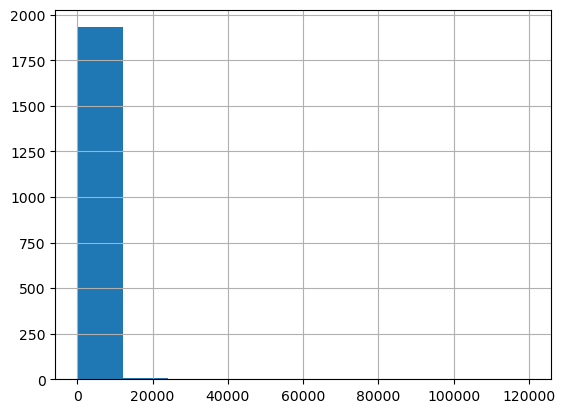

In [90]:
# distribution of text length
train_chat['text'].str.len().hist()

In [98]:
# select rows with text length less than or equal to 10000
large_text = train_chat[train_chat['text'].str.len() >= 8000]
large_text

,instruction,input,output,text
39,Hoe schrijf ik een wilsverklaring?,NaN,In een wilsverklaring zet u op papier welke me...,<s>[INST] Hoe schrijf ik een wilsverklaring? [...
75,Hoe kan ik mij als zelfstandig ondernemer verz...,NaN,Als ondernemer kunt u zelf bepalen hoe u zich ...,<s>[INST] Hoe kan ik mij als zelfstandig onder...
81,Wat betekent de Dienstenrichtlijn voor overheden?,NaN,Ondernemers moeten zich in Nederland vrij kunn...,<s>[INST] Wat betekent de Dienstenrichtlijn vo...
189,Hoe kan ik als zij-instromer mijn bevoegdheid ...,NaN,Met de juiste vooropleiding en ervaring kunt u...,<s>[INST] Hoe kan ik als zij-instromer mijn be...
540,Voor welke technische studies heb ik een onthe...,NaN,De VN en de EU verplichten landen om te voorko...,<s>[INST] Voor welke technische studies heb ik...
569,Wanneer gaat mijn tijdelijke contract over in ...,NaN,Sinds 1 januari 2020 gaat een tijdelijk contra...,<s>[INST] Wanneer gaat mijn tijdelijke contrac...
581,Welke contracten zijn er voor oproepkrachten?,NaN,Er zijn 3 soorten oproepcontracten: een oproep...,<s>[INST] Welke contracten zijn er voor oproep...
685,Hoe regelen basisscholen de schooltijden en le...,NaN,De basisschool bepaalt zelf de indeling van de...,<s>[INST] Hoe regelen basisscholen de schoolti...
761,Hoe hoog is de transitievergoeding als ik word...,NaN,De hoogte van de transitievergoeding die uw we...,<s>[INST] Hoe hoog is de transitievergoeding a...
916,Welke achternaam kan ik voor mijn kind kiezen?,NaN,U kunt voor uw kind de achternaam van de moede...,<s>[INST] Welke achternaam kan ik voor mijn ki...


In [99]:
train_chat = train_chat[train_chat['text'].str.len() <= 8000]

In [100]:
print(f"Number of rows after removing rows with text longer than 1000: {len(train_chat)}")

Number of rows after removing rows with text longer than 1000: 1911


In [101]:
# save to csv
train_chat.to_csv('../Model Finetuning/train_chat_no_large_text.csv', index=False)